# Auricular shape analysis - curvature descriptors

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import trimesh
from PIL import Image

In [2]:
sys.path.append("../..")

from projects.auricular.projection import computeHeightmap, regularSampling, getDistanceToEdge
from projects.auricular.curvaturedescriptors import CurvatureDescriptorsParams
from projects.auricular.curvaturedescriptors import CurvatureDescriptors
from projects.auricular.curvaturedescriptors import HistogramDescriptors
from projects.auricular.common import getSample

In [3]:
input_data = os.path.expanduser("~/data/aurikularni_plocha_ply5/")
sample = list(getSample(input_data))
params = CurvatureDescriptorsParams(
    input_data=input_data,
    sampling_method='regular',
    dist=2.0,
    sampling_rate=0.5,
    sample_count=5000,
    output='../../../output_812')
cd = CurvatureDescriptors(params)

## Compute descriptors

In [4]:
logging.basicConfig(level=logging.INFO)
cd.newAnalysis()
cd.computeDescriptors()

INFO:root:Function "computeDescriptors" took 18.590082 seconds to complete.


In [5]:
data = cd.getData()

### Distance

In [ ]:
heightmap = computeHeightmap(trimesh.load_mesh(sample[10]['filename']), 1.0)
plt.imshow(heightmap)
plt.show()
plt.imshow(getDistanceToEdge(heightmap > np.min(heightmap)))

In [ ]:
bins = 15
normalize = False

hd = HistogramDescriptors(data, 0.5)
range2d = [[-10, 0],[0, 1 if normalize else 32]]
_ = plt.hist2d(*hd.getCurveDistFeatures(0, normalize), bins=bins, range=range2d)
plt.show()
_ = plt.hist2d(*hd.getCurveDistFeatures(811, normalize), bins=bins, range=range2d)

## Sample age distribution

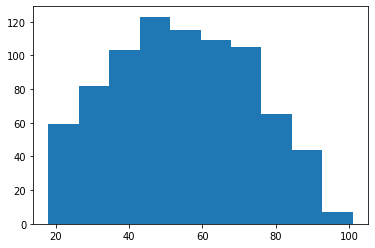

,0
count,812.000000
mean,54.363300
std,18.960138
min,18.000000
25%,38.000000
50%,54.000000
75%,69.000000
max,101.000000


In [7]:
age=[float(specimen['age']) for specimen in sample]
plt.hist(age)
plt.show()
pd.DataFrame(age).describe()

## Reduced sample age distribution

In [ ]:
reduced_sample = list(getSample(os.path.expanduser("~/data/aurikularni_plocha_ply2/")))
reduced_sample_age = [float(specimen['age']) for specimen in reduced_sample]
plt.hist(reduced_sample_age)
plt.show()
pd.DataFrame(reduced_sample_age).describe()

## Data viewer

In [ ]:
trimesh.load(sample[3]['filename']).show()

In [ ]:
plt.imshow(Image.open(os.path.join('../../../output', sample[0]['basename'] + '_sample_map.png'), 'r'))

In [ ]:
plt.imshow(Image.open(os.path.join('../../../output', sample[307]['basename'] + '_sample_map.png'), 'r'))

## Load computed data

In [6]:
data = cd.getData()
hist_descriptors = {
    0.5: HistogramDescriptors(data, 0.5),
    1.0: HistogramDescriptors(data, 1.0),
    2.0: HistogramDescriptors(data, 2.0)
}

In [ ]:
data[0]['dist'][2.0]['curvature'].mean()

In [ ]:
data[0]['dist'][2.0]['sampled_dne']

In [ ]:
data[0]

In [8]:
df = pd.DataFrame(data=[[
                    data1['name'],
                    data1['subset'],
                    data1['type'],
                    data1['side'],
                    data1['sex'],
                    float(data1['age']),
                    float(data1['dist'][2.0]['sampled_dne']),
                    np.log(float(data1['dist'][2.0]['sampled_dne']))] for data1 in data],
                  columns = ['name', 'subset', 'type', 'side', 'sex', 'age', 'meandne', 'log(meandne)'])

df.head()

,name,subset,type,side,sex,age,meandne,log(meandne)
0,LAU_13,S,aur,sin,M,18.0,0.012692,-4.366779
1,MOI_11,S,aur,sin,F,18.0,0.014818,-4.211938
2,53,Cr,aur,dex,F,19.0,0.013796,-4.283401
3,BIE_27,S,aur,dex,M,20.0,0.015350,-4.176626
4,AIG_44,S,aur,dex,M,20.0,0.014754,-4.216244


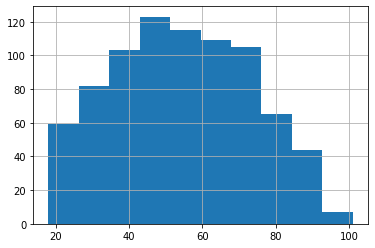

In [9]:
df['age'].hist();

In [10]:
df.groupby(['subset'])['subset'].describe()[["count"]]

,count
subset,
Co1,143
Co2,183
Cr,75
S,159
Th,252


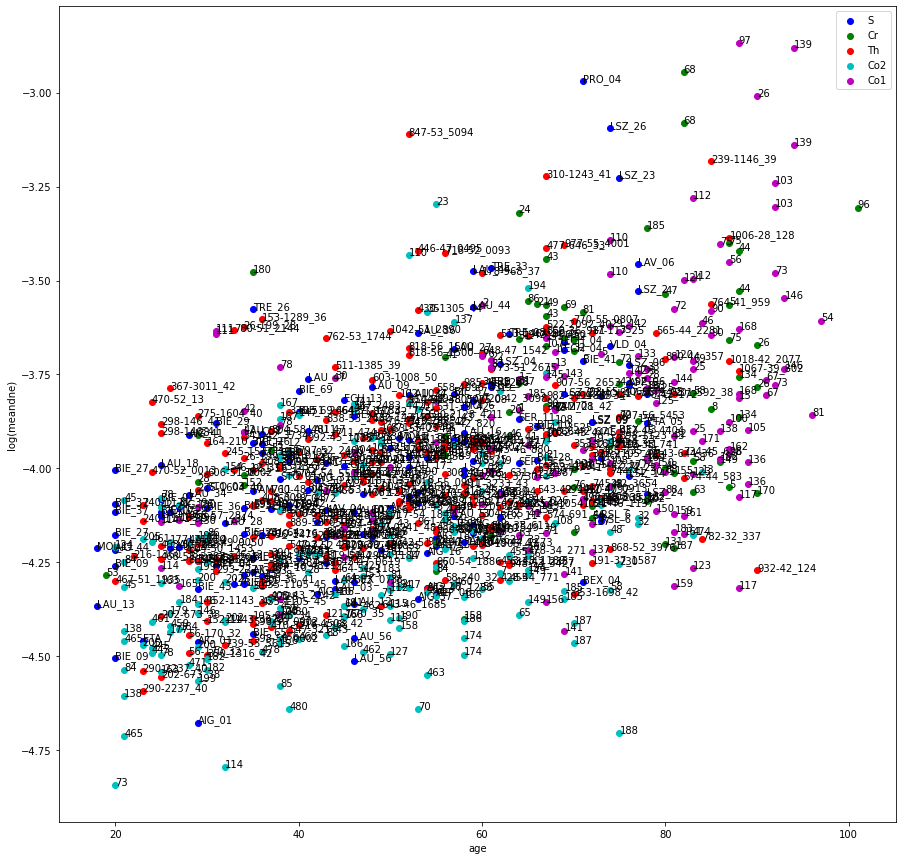

In [11]:
cols = {a[0]: a[1] for a in zip(df['subset'].unique(), mcolors.BASE_COLORS.keys())}

fig, ax = plt.subplots(figsize=(15,15))
for subset, color in cols.items():
    df1 = df[df['subset']==subset]
    ax.scatter(df1['age'], df1['log(meandne)'], c=color, label=subset)
ax.legend()
df[['age','log(meandne)','name']].apply(lambda x: ax.text(*x), axis=1)
plt.xlabel("age")
plt.ylabel("log(meandne)");

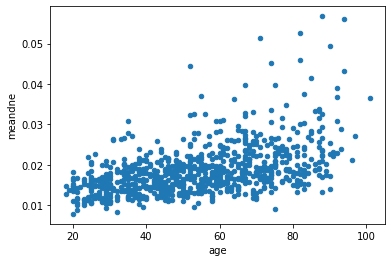

In [12]:
df.plot.scatter(x='age', y='meandne')